#Load Dataset

In [1]:
!pip install patool

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.4/98.4 kB 3.6 MB/s eta 0:00:00


In [2]:
import patoolib
import os

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
zip_file_path = '/content/drive/My Drive/raw_data2.zip'
extraction_dir = '/content/'

In [5]:
# Unzipping
patoolib.extract_archive(zip_file_path, outdir=extraction_dir)

print(f"Unzipped data to: {extraction_dir}")

INFO patool: Extracting /content/drive/My Drive/raw_data2.zip ...
INFO:patool:Extracting /content/drive/My Drive/raw_data2.zip ...
INFO patool: running /usr/bin/7z x -aou -o/content/ -- "/content/drive/My Drive/raw_data2.zip"
INFO:patool:running /usr/bin/7z x -aou -o/content/ -- "/content/drive/My Drive/raw_data2.zip"
INFO patool: ... /content/drive/My Drive/raw_data2.zip extracted to `/content/'.
INFO:patool:... /content/drive/My Drive/raw_data2.zip extracted to `/content/'.


Unzipped data to: /content/


# Basic Model

In [6]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import os
import numpy as np
import matplotlib.pyplot as plt

##Create train datasets

In [7]:
data_dir = os.path.join(os.getcwd(),'raw_data')

batch_size = 32
img_height = 224
img_width = 224

train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 10970 files belonging to 2 classes.
Using 8776 files for training.


## Create validation datasets

In [8]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 10970 files belonging to 2 classes.
Using 2194 files for validation.


## Create test datasets

In [9]:
val_batches = tf.data.experimental.cardinality(val_ds)
test_ds = val_ds.take(val_batches // 5)
val_ds = val_ds.skip(val_batches // 5)

In [10]:
class_names = train_ds.class_names
print(class_names)

['no_nsfw', 'nsfw']


In [11]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [12]:
# num_classes = len(class_names)

model = Sequential([
    Input(shape=(img_height, img_width, 3)),
    layers.Rescaling(1./255),
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

In [13]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [14]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)                │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 224, 224, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 112, 112, 16)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 112, 112, 32)        │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 56, 56, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 56, 56, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 28, 28, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 50176)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       6,422,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,446,369 (24.59 MB)

 Trainable params: 6,446,369 (24.59 MB)

 Non-trainable params: 0 (0.00 B)

In [15]:
epochs = 10

history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
275/275 ━━━━━━━━━━━━━━━━━━━━ 128s 128ms/step - accuracy: 0.7407 - loss: 0.5696 - val_accuracy: 0.8386 - val_loss: 0.3649
Epoch 2/10
275/275 ━━━━━━━━━━━━━━━━━━━━ 22s 24ms/step - accuracy: 0.8667 - loss: 0.3166 - val_accuracy: 0.8886 - val_loss: 0.2674
Epoch 3/10
275/275 ━━━━━━━━━━━━━━━━━━━━ 6s 23ms/step - accuracy: 0.9153 - loss: 0.2110 - val_accuracy: 0.8999 - val_loss: 0.2514
Epoch 4/10
275/275 ━━━━━━━━━━━━━━━━━━━━ 7s 24ms/step - accuracy: 0.9416 - loss: 0.1439 - val_accuracy: 0.8898 - val_loss: 0.3013
Epoch 5/10
275/275 ━━━━━━━━━━━━━━━━━━━━ 6s 23ms/step - accuracy: 0.9665 - loss: 0.0862 - val_accuracy: 0.8645 - val_loss: 0.3598
Epoch 6/10
275/275 ━━━━━━━━━━━━━━━━━━━━ 11s 25ms/step - accuracy: 0.9726 - loss: 0.0693 - val_accuracy: 0.8976 - val_loss: 0.3422
Epoch 7/10
275/275 ━━━━━━━━━━━━━━━━━━━━ 10s 25ms/step - accuracy: 0.9822 - loss: 0.0513 - val_accuracy: 0.8926 - val_loss: 0.4087
Epoch 8/10
275/275 ━━━━━━━━━━━━━━━━━━━━ 7s 24ms/step - accuracy: 0.9946 - loss: 0.0166 - va

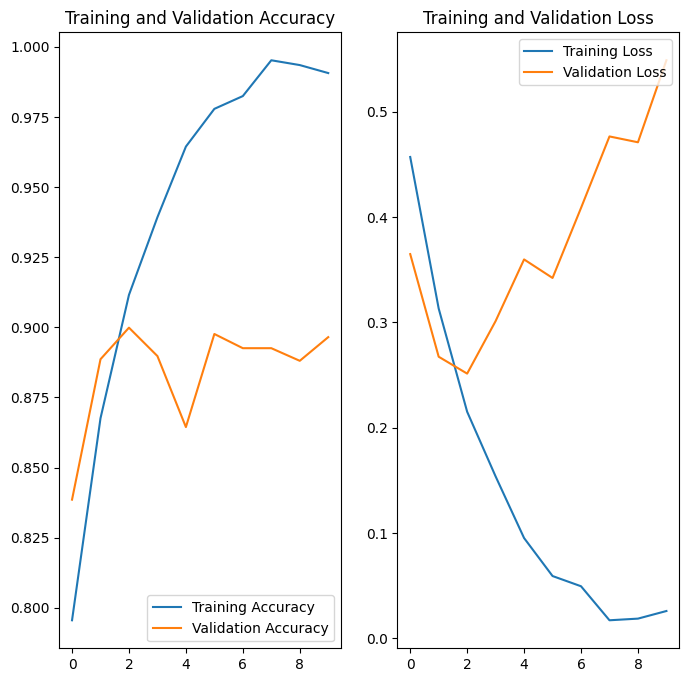

In [16]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [17]:
loss, accuracy = model.evaluate(test_ds)
print('Test accuracy :', accuracy)

13/13 ━━━━━━━━━━━━━━━━━━━━ 4s 306ms/step - accuracy: 0.9061 - loss: 0.3566
Test accuracy : 0.8918269276618958


# Transfer Learning using MobileNet V2

## Data Augmentation

In [18]:
data_augmentation = Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
])

In [19]:
IMG_SHAPE = (img_height, img_width)+(3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


## Feature Extraction

In [20]:
base_model.trainable = False

In [21]:
base_model.summary()

Model: "mobilenetv2_1.00_224"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1 (Conv2D)            │ (None, 112, 112, 32)   │            864 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bn_Conv1                  │ (None, 112, 112, 32)   │            128 │ Conv1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1_relu (ReLU)         │ (None, 112, 112, 32)   │              0 │ bn_Conv1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise   │ (None, 112, 112, 32)   │            288 │ Conv1_relu[0][0]       │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 112, 112, 32)   │            128 │ expanded_conv_depthwi… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 112, 112, 32)   │              0 │ expanded_conv_depthwi… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project     │ (None, 112, 112, 16)   │            512 │ expanded_conv_depthwi… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project_BN  │ (None, 112, 112, 16)   │             64 │ expanded_conv_project… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand (Conv2D)   │ (None, 112, 112, 96)   │          1,536 │ expanded_conv_project… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_BN         │ (None, 112, 112, 96)   │            384 │ block_1_expand[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_relu       │ (None, 112, 112, 96)   │              0 │ block_1_expand_BN[0][… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_pad               │ (None, 113, 113, 96)   │              0 │ block_1_expand_relu[0… │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise         │ (None, 56, 56, 96)     │            864 │ block_1_pad[0][0]      │
│ (DepthwiseConv2D)         │                        │                │                        │
├──────────────────────

 Total params: 2,257,984 (8.61 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 2,257,984 (8.61 MB)

## Add a classification head

In [ ]:
# image_batch, label_batch = next(iter(train_ds))
# feature_batch = base_model(image_batch)

In [ ]:
# global_average_layer = layers.GlobalAveragePooling2D()
# feature_batch_average = global_average_layer(feature_batch)

In [ ]:
# prediction_layer = tf.keras.layers.Dense(num_classes)
# prediction_batch = prediction_layer(feature_batch_average)
# print(prediction_batch.shape)

(32, 5)


In [22]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

In [23]:
inputs = tf.keras.Input(shape=(224, 224, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
# x = global_average_layer(x)
x = layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.2)(x)
# outputs = prediction_layer(x)
outputs = layers.Dense(1, activation='sigmoid')(x)
model = tf.keras.Model(inputs, outputs)

In [24]:
model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_1 (Sequential)            │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ true_divide (TrueDivide)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ subtract (Subtract)                  │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ mobilenetv2_1.00_224 (Functional)    │ (None, 7, 7, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 1280)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │           1,281 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,259,265 (8.62 MB)

 Trainable params: 1,281 (5.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

## Compile & Train

In [28]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [29]:
initial_epochs = 20

loss0, accuracy0 = model.evaluate(val_ds)

56/56 ━━━━━━━━━━━━━━━━━━━━ 6s 47ms/step - accuracy: 0.4445 - loss: 0.8804


In [30]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 0.88
initial accuracy: 0.44


In [31]:
history = model.fit(train_ds,
                    epochs=initial_epochs,
                    validation_data=val_ds)

Epoch 1/20
275/275 ━━━━━━━━━━━━━━━━━━━━ 23s 61ms/step - accuracy: 0.5654 - loss: 0.7361 - val_accuracy: 0.8543 - val_loss: 0.4053
Epoch 2/20
275/275 ━━━━━━━━━━━━━━━━━━━━ 16s 59ms/step - accuracy: 0.8339 - loss: 0.4002 - val_accuracy: 0.9016 - val_loss: 0.2964
Epoch 3/20
275/275 ━━━━━━━━━━━━━━━━━━━━ 21s 59ms/step - accuracy: 0.8807 - loss: 0.3055 - val_accuracy: 0.9111 - val_loss: 0.2569
Epoch 4/20
275/275 ━━━━━━━━━━━━━━━━━━━━ 16s 60ms/step - accuracy: 0.8949 - loss: 0.2712 - val_accuracy: 0.9111 - val_loss: 0.2375
Epoch 5/20
275/275 ━━━━━━━━━━━━━━━━━━━━ 20s 59ms/step - accuracy: 0.9052 - loss: 0.2457 - val_accuracy: 0.9134 - val_loss: 0.2306
Epoch 6/20
275/275 ━━━━━━━━━━━━━━━━━━━━ 21s 61ms/step - accuracy: 0.9144 - loss: 0.2217 - val_accuracy: 0.9151 - val_loss: 0.2229
Epoch 7/20
275/275 ━━━━━━━━━━━━━━━━━━━━ 16s 60ms/step - accuracy: 0.9107 - loss: 0.2209 - val_accuracy: 0.9179 - val_loss: 0.2169
Epoch 8/20
275/275 ━━━━━━━━━━━━━━━━━━━━ 17s 60ms/step - accuracy: 0.9176 - loss: 0.2086 - 

In [32]:
loss, accuracy = model.evaluate(test_ds)
print('Test accuracy :', accuracy)

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - accuracy: 0.9516 - loss: 0.1627
Test accuracy : 0.942307710647583


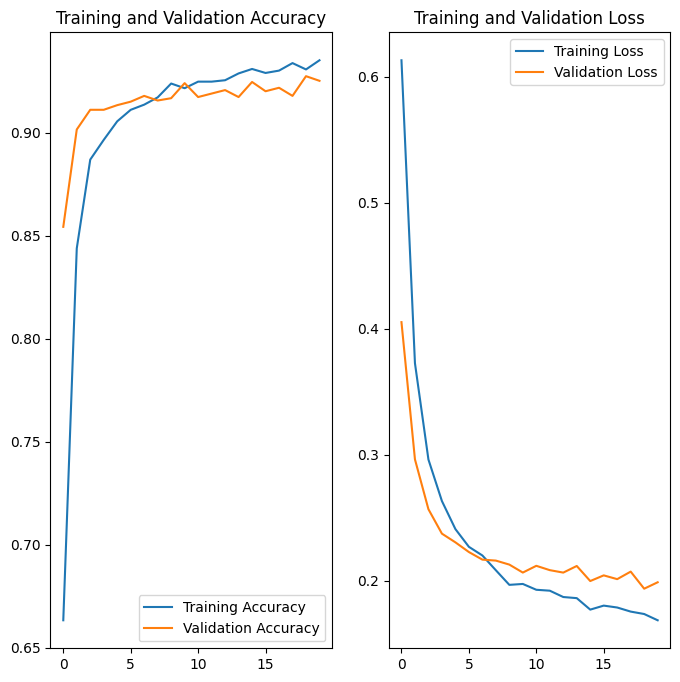

In [33]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(initial_epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Fine Tuning

In [34]:
base_model.trainable = True

In [35]:
print("Number of layers in the base model: ", len(base_model.layers))

Number of layers in the base model:  154


In [36]:
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

In [37]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
              optimizer = tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              metrics=['accuracy'])

In [38]:
model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_1 (Sequential)            │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ true_divide (TrueDivide)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ subtract (Subtract)                  │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ mobilenetv2_1.00_224 (Functional)    │ (None, 7, 7, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 1280)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │           1,281 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,259,265 (8.62 MB)

 Trainable params: 1,862,721 (7.11 MB)

 Non-trainable params: 396,544 (1.51 MB)

In [40]:
callbacks = [
    EarlyStopping(monitor='val_loss',
                  patience=5,
                  restore_best_weights=True),
    ModelCheckpoint('best_model.weights.h5',
                    monitor='val_loss',
                    save_best_only=True,
                    save_weights_only=True)
]

In [41]:
fine_tune_epochs = 20
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_ds,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=val_ds,
                         callbacks=callbacks)

Epoch 20/40
275/275 ━━━━━━━━━━━━━━━━━━━━ 48s 102ms/step - accuracy: 0.9034 - loss: 0.2399 - val_accuracy: 0.8729 - val_loss: 0.5922
Epoch 21/40
275/275 ━━━━━━━━━━━━━━━━━━━━ 26s 94ms/step - accuracy: 0.9704 - loss: 0.0795 - val_accuracy: 0.8678 - val_loss: 0.6367
Epoch 22/40
275/275 ━━━━━━━━━━━━━━━━━━━━ 28s 101ms/step - accuracy: 0.9831 - loss: 0.0463 - val_accuracy: 0.9145 - val_loss: 0.3774
Epoch 23/40
275/275 ━━━━━━━━━━━━━━━━━━━━ 40s 96ms/step - accuracy: 0.9894 - loss: 0.0327 - val_accuracy: 0.8971 - val_loss: 0.4382
Epoch 24/40
275/275 ━━━━━━━━━━━━━━━━━━━━ 27s 99ms/step - accuracy: 0.9934 - loss: 0.0218 - val_accuracy: 0.9528 - val_loss: 0.1922
Epoch 25/40
275/275 ━━━━━━━━━━━━━━━━━━━━ 29s 105ms/step - accuracy: 0.9922 - loss: 0.0196 - val_accuracy: 0.9589 - val_loss: 0.1785
Epoch 26/40
275/275 ━━━━━━━━━━━━━━━━━━━━ 29s 107ms/step - accuracy: 0.9963 - loss: 0.0131 - val_accuracy: 0.9466 - val_loss: 0.3031
Epoch 27/40
275/275 ━━━━━━━━━━━━━━━━━━━━ 27s 98ms/step - accuracy: 0.9947 - los

In [42]:
acc = []
val_acc = []
loss = []
val_loss = []

acc.extend(history_fine.history['accuracy'])
val_acc.extend(history_fine.history['val_accuracy'])
loss.extend(history_fine.history['loss'])
val_loss.extend(history_fine.history['val_loss'])


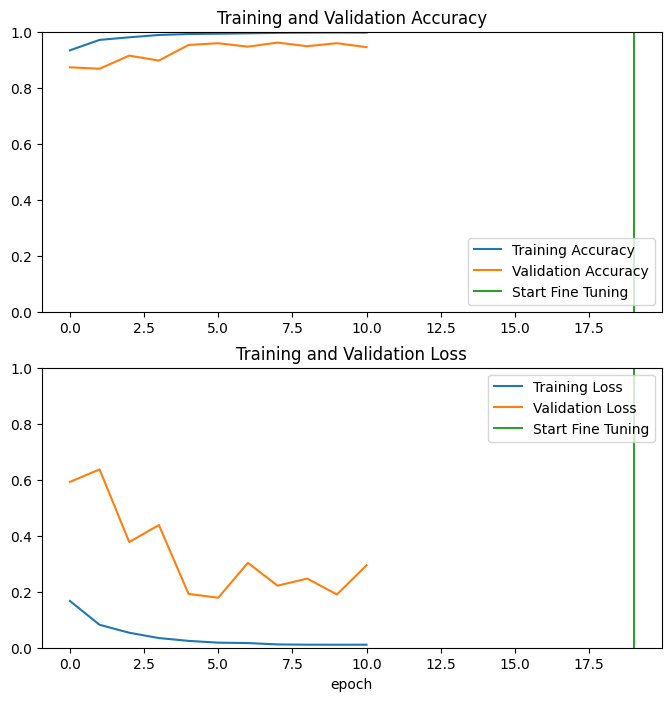

In [43]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [44]:
loss, accuracy = model.evaluate(test_ds)
print('Test accuracy :', accuracy)

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.9763 - loss: 0.1501
Test accuracy : 0.96875


In [45]:
model.save('nsfw_binary_classification.keras')

# Predict

In [46]:
from tensorflow.keras.preprocessing import image

In [50]:
def preprocess_image(image_path, target_size=(224, 224)):
    img = image.load_img(image_path, target_size=target_size)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)

    img_array = tf.keras.applications.mobilenet_v2.preprocess_input(img_array)

    return img_array

In [62]:
def predict_image(image_path, model):
    img_array = preprocess_image(image_path)
    predictions = model.predict(img_array)
    class_label = "nsfw" if predictions[0] > 0.3 else "no nsfw"
    return predictions[0], class_label

In [63]:
image_path = 'test_no_nsfw.jpg'
probability, class_label = predict_image(image_path, model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


In [64]:
print(f"Predicted Class: {class_label}")
print(f"Prediction Probability: {probability}")

Predicted Class: no nsfw
Prediction Probability: [0.00031339]


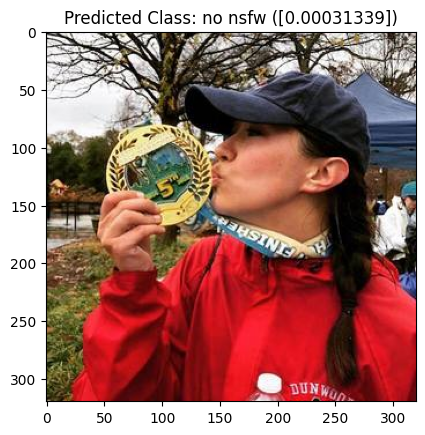

In [65]:
img = image.load_img(image_path)
plt.imshow(img)
plt.title(f"Predicted Class: {class_label} ({probability})")
plt.show()